# 提取特定条件试次（分段）

本节的目的是根据触发通道提取试验。我们将解释如何从刺激通道产生事件，以及如何提取特定条件的试次（分段）。一旦提取了试次，将基于不良分段的峰间信号幅度来识别和排除不良分段。

## Preparation

Import the relevant Python modules:

In [2]:
import os.path as op
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import mne
from mne_bids import BIDSPath, read_raw_bids

### File overview
The chapter relies on the input file (embedded in the BIDS structure):
~~~
<BIDS_ROOT>/derivatives/Preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_ica.fif
<BIDS_ROOT>/derivatives/Preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-02_ica.fif

<BIDS_ROOT>/derivatives/Preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_ann.fif
<BIDS_ROOT>/derivatives/Preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-02_ann.fif
~~~
and generates the output files
~~~
<BIDS_ROOT>/derivatives/Analysis/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-12_epo.fif
~~~

Set the paths for the data and results. Note that these will depend on your local setup.

In [3]:
subject = '01'
session = '01'
task = 'SpAtt'
run = '02'
meg_suffix = 'meg'
ica_suffix = 'ica'
epo_suffix = 'epo'

preproc_root = '/home/ubuntu/database/ds004346-FLUX/derivatives/preprocessing'
deriv_root = '/home/ubuntu/database/ds004346-FLUX/derivatives/analysis'

bids_path_preproc = BIDSPath(subject=subject, session=session,
            task=task, run=run, suffix=ica_suffix, datatype='meg',
            root=preproc_root, extension='.fif', check=False)

bids_path = BIDSPath(subject=subject, session=session,
            task=task, run=run, suffix=epo_suffix, datatype='meg',
            root=deriv_root, extension='.fif', check=False).mkdir()

deriv_file = bids_path.basename.replace('run-01', 'run-12')  # run 12 -> run 01 concatenated with run 02
deriv_fname = op.join(bids_path.directory, deriv_file)

print(bids_path_preproc.fpath)
print(deriv_fname)

/home/ubuntu/database/ds004346-FLUX/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-02_ica.fif
/home/ubuntu/database/ds004346-FLUX/derivatives/analysis/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-02_epo.fif


## 从刺激通道读取事件

首先读取刺激通道中的所有事件（在我们的案例中，STI01）。我们将对上一步中创建的2个fif文件进行循环。

In [4]:
# This section only runs on run=02 for illustration purposes
raw = read_raw_bids(bids_path=bids_path_preproc, 
            extra_params={'preload':False},
            verbose=True)

Opening raw data file /home/ubuntu/database/ds004346-FLUX/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-02_ica.fif...
    Range : 1665000 ... 3098999 =   1665.000 ...  3098.999 secs
Ready.


/tmp/ipykernel_747351/765722075.py:2: RuntimeWarning: This filename (/home/ubuntu/database/ds004346-FLUX/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-02_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path_preproc,
/tmp/ipykernel_747351/765722075.py:2: RuntimeWarning: Did not find any events.tsv associated with sub-01_ses-01_task-SpAtt_run-02.

The search_str was "/home/ubuntu/database/ds004346-FLUX/derivatives/preprocessing/sub-01/**/meg/sub-01_ses-01*events.tsv"
  raw = read_raw_bids(bids_path=bids_path_preproc,
/tmp/ipykernel_747351/765722075.py:2: RuntimeWarning: Did not find any channels.tsv associated with sub-01_ses-01_task-SpAtt_run-02.

The search_str was "/home/ubuntu/database/ds004346-FLUX/derivatives/preprocessing/sub-01/**/m

In [5]:
# Reading the events from the raw file
events, events_id = mne.events_from_annotations(raw, event_id='auto')

Used Annotations descriptions: [np.str_('ITI'), np.str_('blink'), np.str_('block_start'), np.str_('cue_left'), np.str_('cue_right'), np.str_('left_resp_maybe'), np.str_('right_resp_maybe'), np.str_('target_onset'), np.str_('trial_end'), np.str_('trial_start')]


上面的代码从触发信道STI101中提取事件。这些结果在数组*events*中表示，其中第一列是样本，第三列是相应的触发值。events_id是事件名称和触发器代码的字典。

要可视化事件数组的片段，请编写：

Using matplotlib as 2D backend.


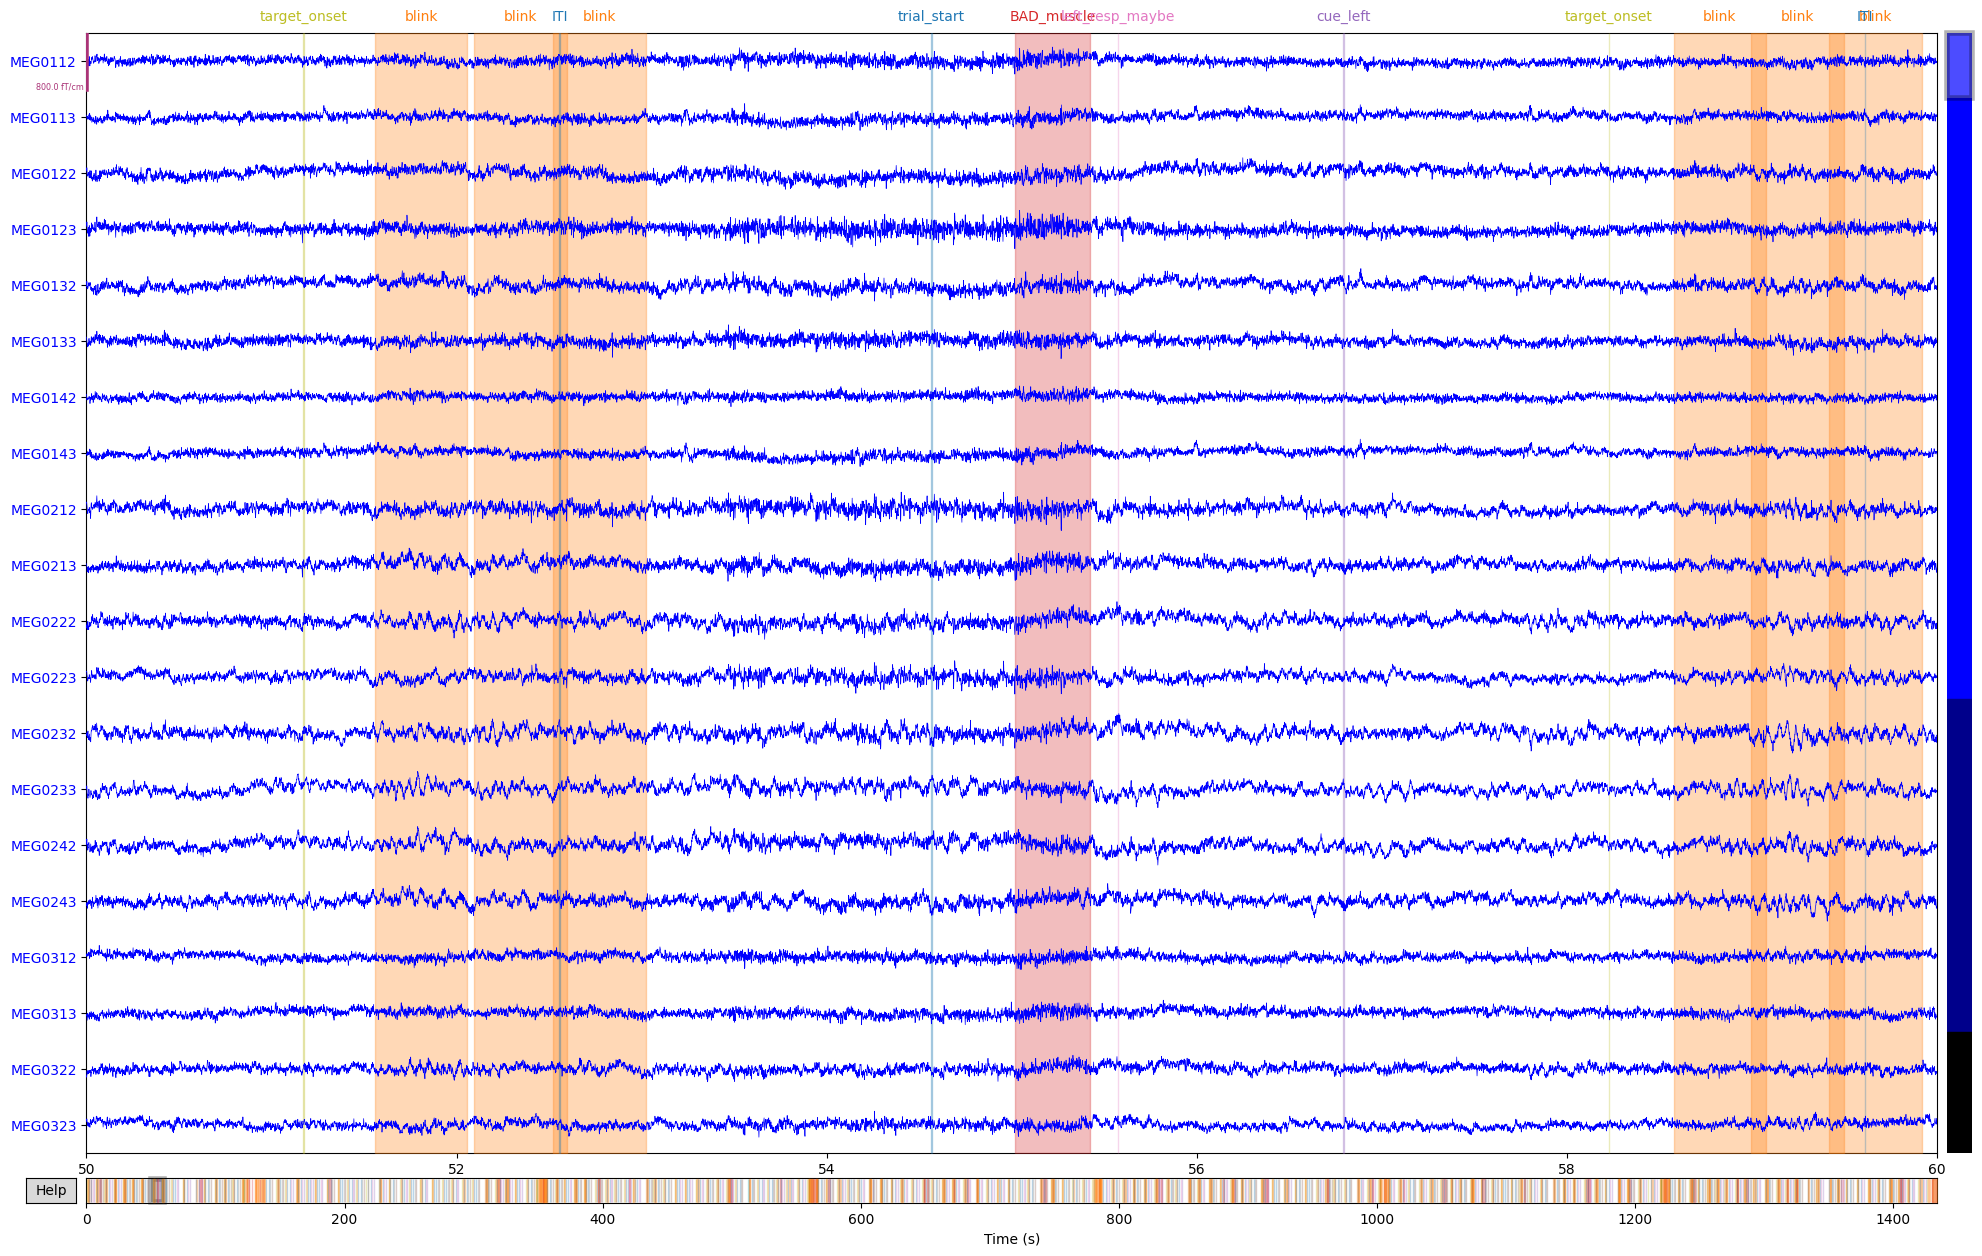

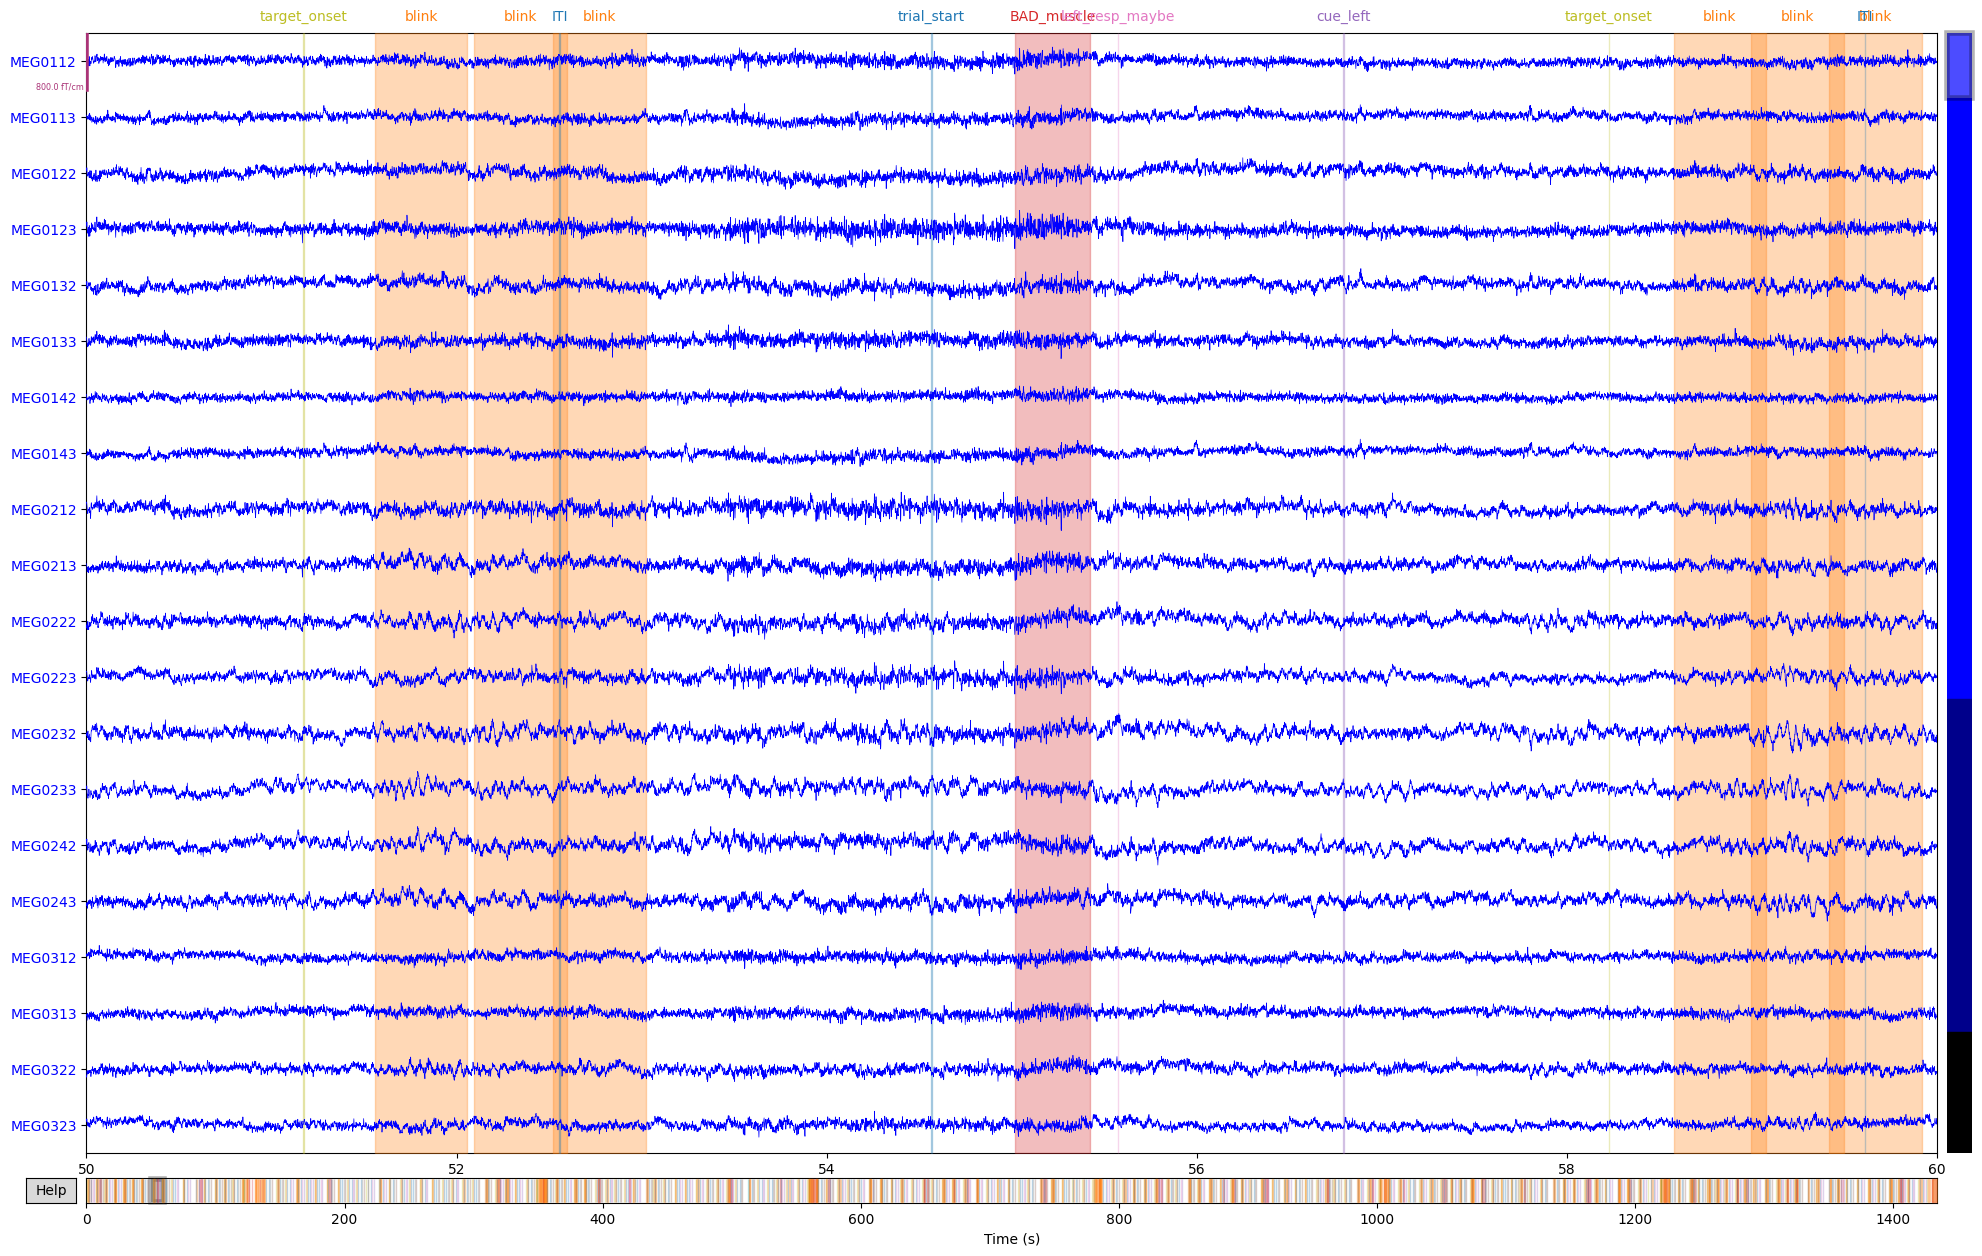

In [5]:
%matplotlib inline
raw.plot(start=50)

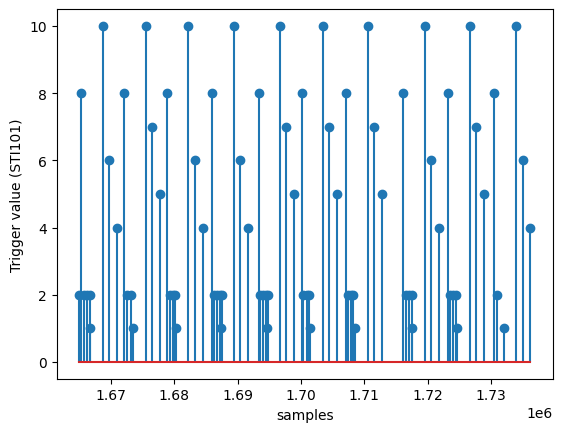

In [6]:
%matplotlib inline
plt.stem(events[:,0][:80], events[:,2][:80]) # plot the first 80 events
plt.xlabel('samples')
plt.ylabel('Trigger value (STI101)')
plt.show()

图中显示了部分事件数组的示例。触发值指示试次的特定事件。


## 根据事件值定义分段（试次）

下一步是提取数据的两个子部分的左试验和右试验：

> 这里是先提取了需要的事件，然后再进行分段；也可以先根据所有事件进行分段，然后再提取需要事件对应的分段，这样操作起来可以更方便。

In [11]:
raw_list = list()
events_list = list()

# for subfile in range(2):
#     print(subfile)
#     if subfile == 0:
#         bids_path_preproc.update(run='01')
     
#     if subfile == 1:
#         bids_path_preproc.update(run='02')
    
raw = read_raw_bids(bids_path=bids_path_preproc, 
        extra_params={'preload':True},
        verbose=True)

events, events_id = mne.events_from_annotations(raw, event_id='auto')
                
raw_list.append(raw)
events_list.append(events) 
    
# Define event ids we are interested in
events_picks_id = {k:v for k, v in events_id.items() if k.startswith('cue')} 

events_picks_id

Opening raw data file /home/ubuntu/database/ds004346-FLUX/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-02_ica.fif...
    Range : 1665000 ... 3098999 =   1665.000 ...  3098.999 secs
Ready.
Reading 0 ... 1433999  =      0.000 ...  1433.999 secs...


/tmp/ipykernel_747351/2708486901.py:12: RuntimeWarning: This filename (/home/ubuntu/database/ds004346-FLUX/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-02_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path_preproc,
/tmp/ipykernel_747351/2708486901.py:12: RuntimeWarning: Did not find any events.tsv associated with sub-01_ses-01_task-SpAtt_run-02.

The search_str was "/home/ubuntu/database/ds004346-FLUX/derivatives/preprocessing/sub-01/**/meg/sub-01_ses-01*events.tsv"
  raw = read_raw_bids(bids_path=bids_path_preproc,
/tmp/ipykernel_747351/2708486901.py:12: RuntimeWarning: Did not find any channels.tsv associated with sub-01_ses-01_task-SpAtt_run-02.

The search_str was "/home/ubuntu/database/ds004346-FLUX/derivatives/preprocessing/sub-0

Used Annotations descriptions: [np.str_('ITI'), np.str_('blink'), np.str_('block_start'), np.str_('cue_left'), np.str_('cue_right'), np.str_('left_resp_maybe'), np.str_('right_resp_maybe'), np.str_('target_onset'), np.str_('trial_end'), np.str_('trial_start')]


{np.str_('cue_left'): 4, np.str_('cue_right'): 5}

现在将原始实例连接起来，就像它们是连续的一样--即在2个子文件上组合。

In [ ]:
# 这里本来就只加载了一个run02的数据，所以不需要concatenate，但是如果是多个run的数据，就需要concatenate
raw, events = mne.concatenate_raws(raw_list, events_list=events_list)
del raw_list 

Using matplotlib as 2D backend.


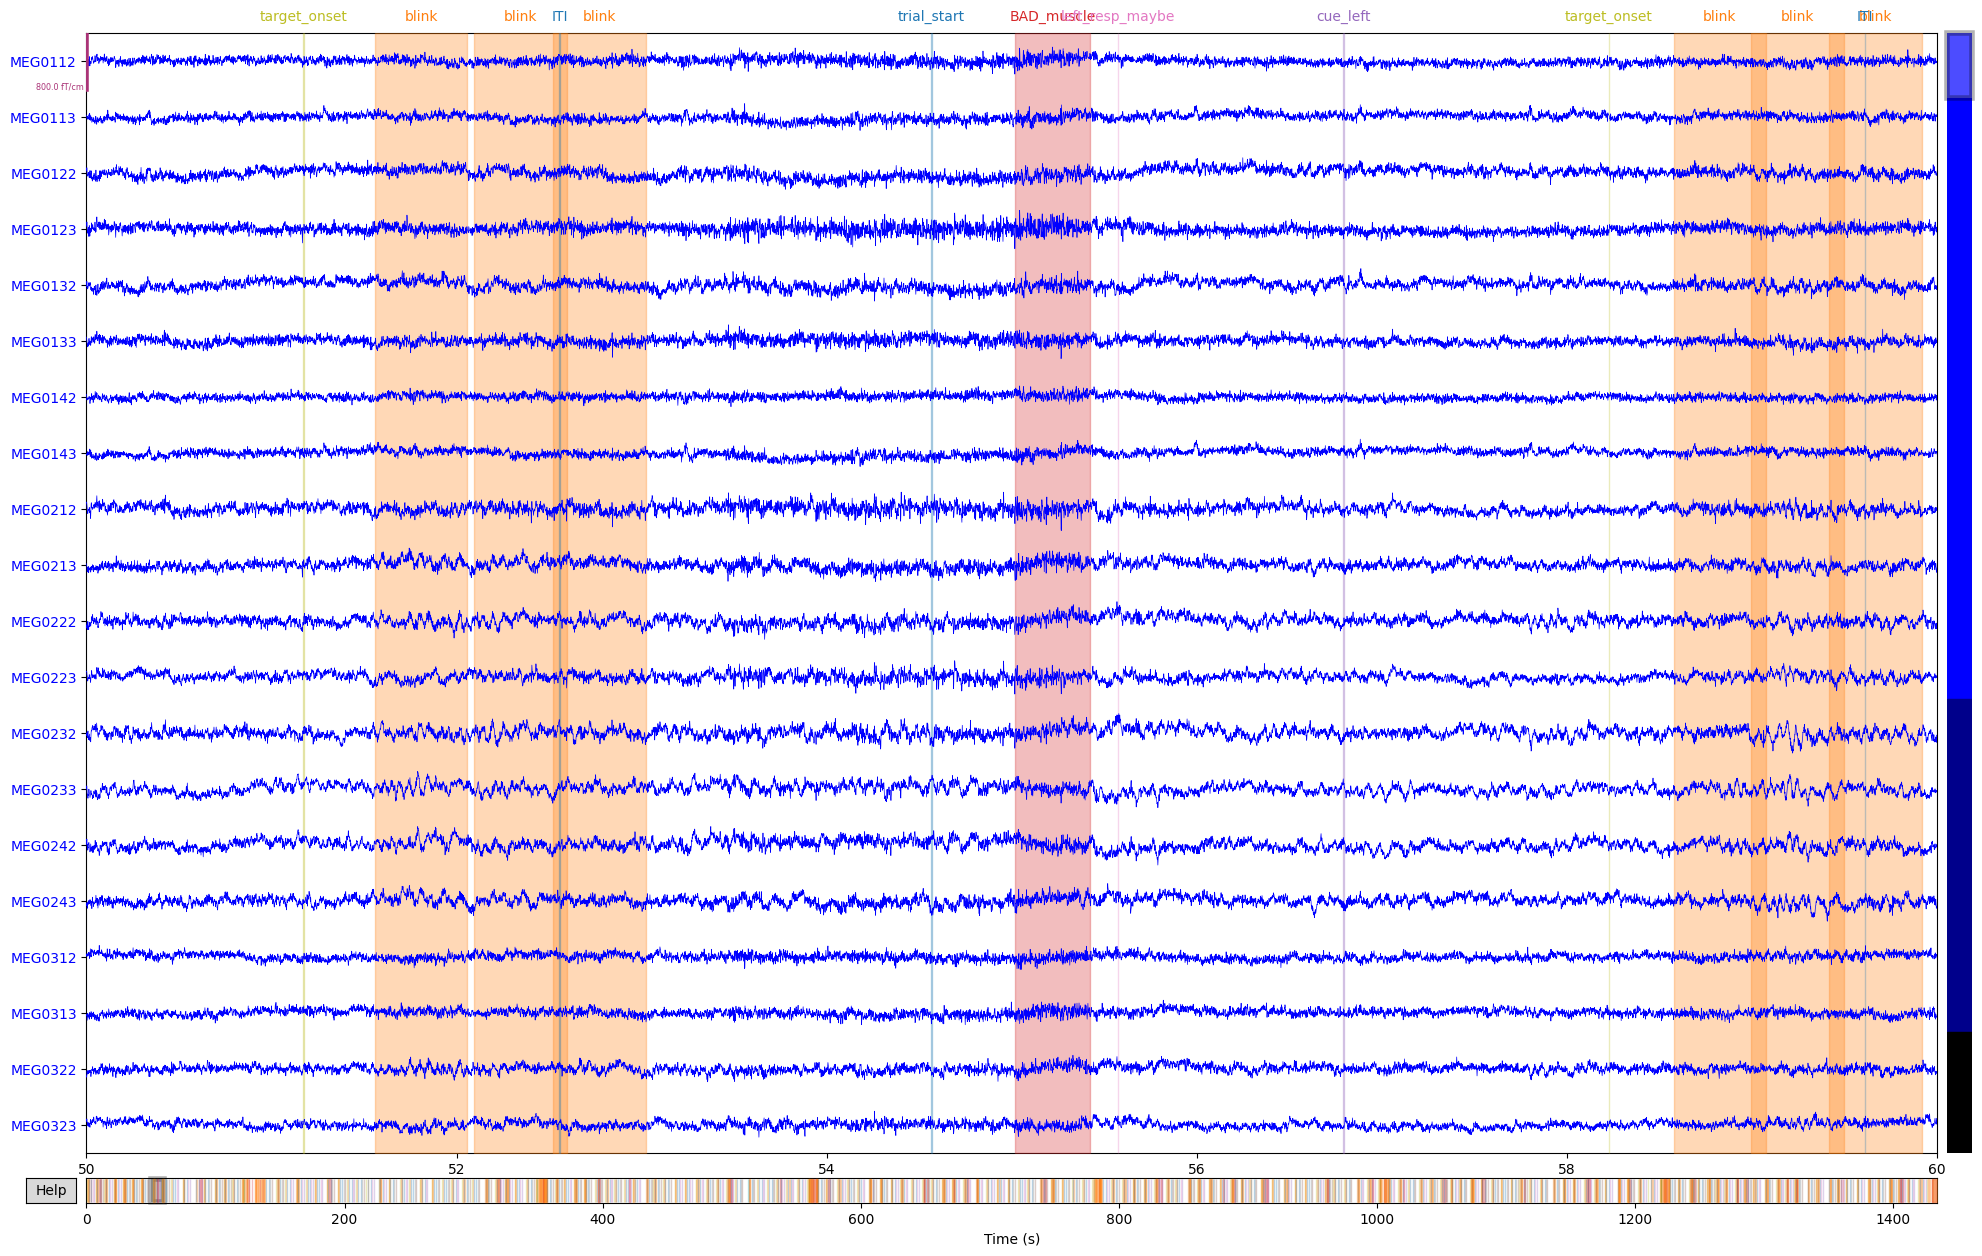

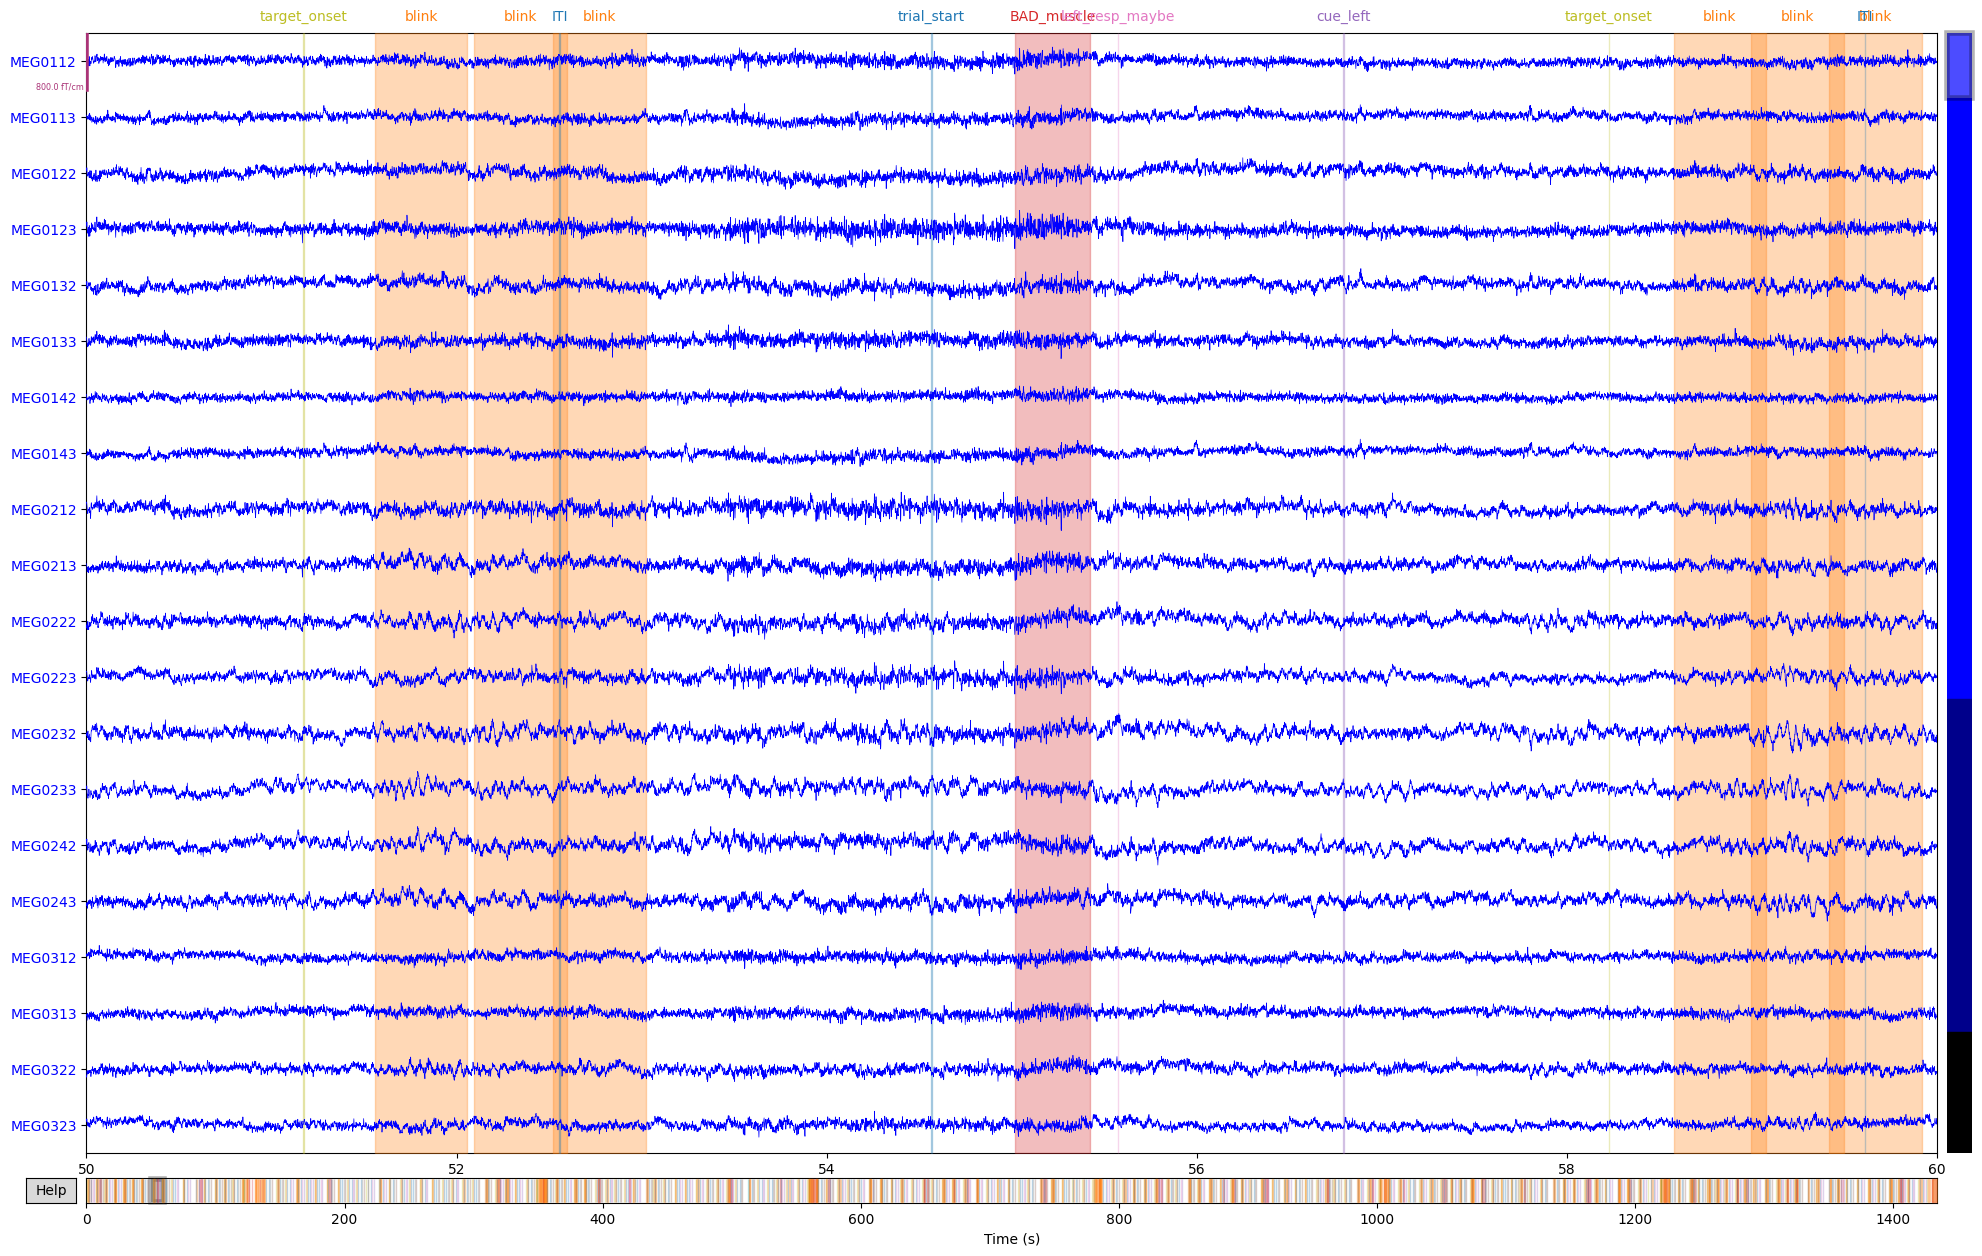

In [13]:
%matplotlib inline
raw.plot(start=50)

设置试验拒绝的峰间幅度阈值。这些值可能会根据数据的质量而变化。

**问题** 如何确定这个阈值？

In [14]:
reject = dict(grad=5000e-13,  # unit: T / m (gradiometers)
              mag=4e-12,      # unit: T (magnetometers)
              #eeg=40e-6,      # unit: V (EEG channels)
              #eog=250e-6      # unit: V (EOG channels)
             )


我们将使用感兴趣的时间窗口，从刺激开始前2.5秒开始，到刺激开始后2秒结束。现在使用events和events_id以及选定的通道执行分段：

In [15]:
# Make epochs (4.5 seconds centered on stim onset)
epochs = mne.Epochs(raw,
            events, events_picks_id,
            tmin=-2.5 , tmax=2,
            baseline=None,
            proj=False,
            picks = 'all',
            detrend = 1,
            reject=reject,
            reject_by_annotation=True,
            preload=True,
            verbose=True)

# Show epochs details
epochs

Not setting metadata
172 matching events found
No baseline correction applied
Using data from preloaded Raw for 172 events and 4501 original time points ...
    Rejecting  epoch based on MAG : ['MEG2411', 'MEG2431']
    Rejecting  epoch based on MAG : ['MEG1321']
    Rejecting  epoch based on MAG : ['MEG1341']
    Rejecting  epoch based on MAG : ['MEG1341', 'MEG2411', 'MEG2421', 'MEG2431']
    Rejecting  epoch based on MAG : ['MEG2431']
    Rejecting  epoch based on MAG : ['MEG2411', 'MEG2431']
    Rejecting  epoch based on MAG : ['MEG1421']
36 bad epochs dropped


<Epochs | 136 events (all good), -2.5 – 2 s (baseline off), ~1.56 GiB, data loaded,
 np.str_('cue_left'): 63
 np.str_('cue_right'): 73>

通过调用*分段*，我们可以检查事件的数量是136个，其中63个是左注意力试验，73个是右注意力试验。此外，我们可以看到在这个阶段没有应用基线校正。

现在我们绘制被拒绝的分段的概述：

> 对于被丢弃的分段，在多模态数据处理中，不同模态数据应该需要同步丢弃相同的分段，以保证数据对齐。如果同时处理多模态数据时，比如eeg和meg，包含在同一个数据文件中，则不存在这个问题

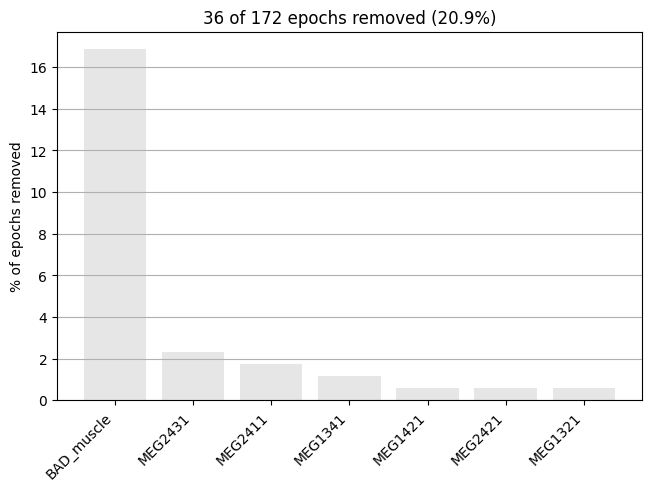

In [16]:
%matplotlib inline
epochs.plot_drop_log();

由于磁强计中的MEG伪影，一小部分试次被拒绝。

现在我们将分段后的数据保存在FIF文件中。请注意，此文件将包含来自2个子文件的试验。
> 此处只有子文件2

In [17]:
print(deriv_fname)

/home/ubuntu/database/ds004346-FLUX/derivatives/analysis/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-02_epo.fif


In [18]:
epochs.save(deriv_fname, overwrite=True)

[PosixPath('/home/ubuntu/database/ds004346-FLUX/derivatives/analysis/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-02_epo.fif')]

## 试次绘图
要显示MEG梯度仪左侧事件的试次，请写：

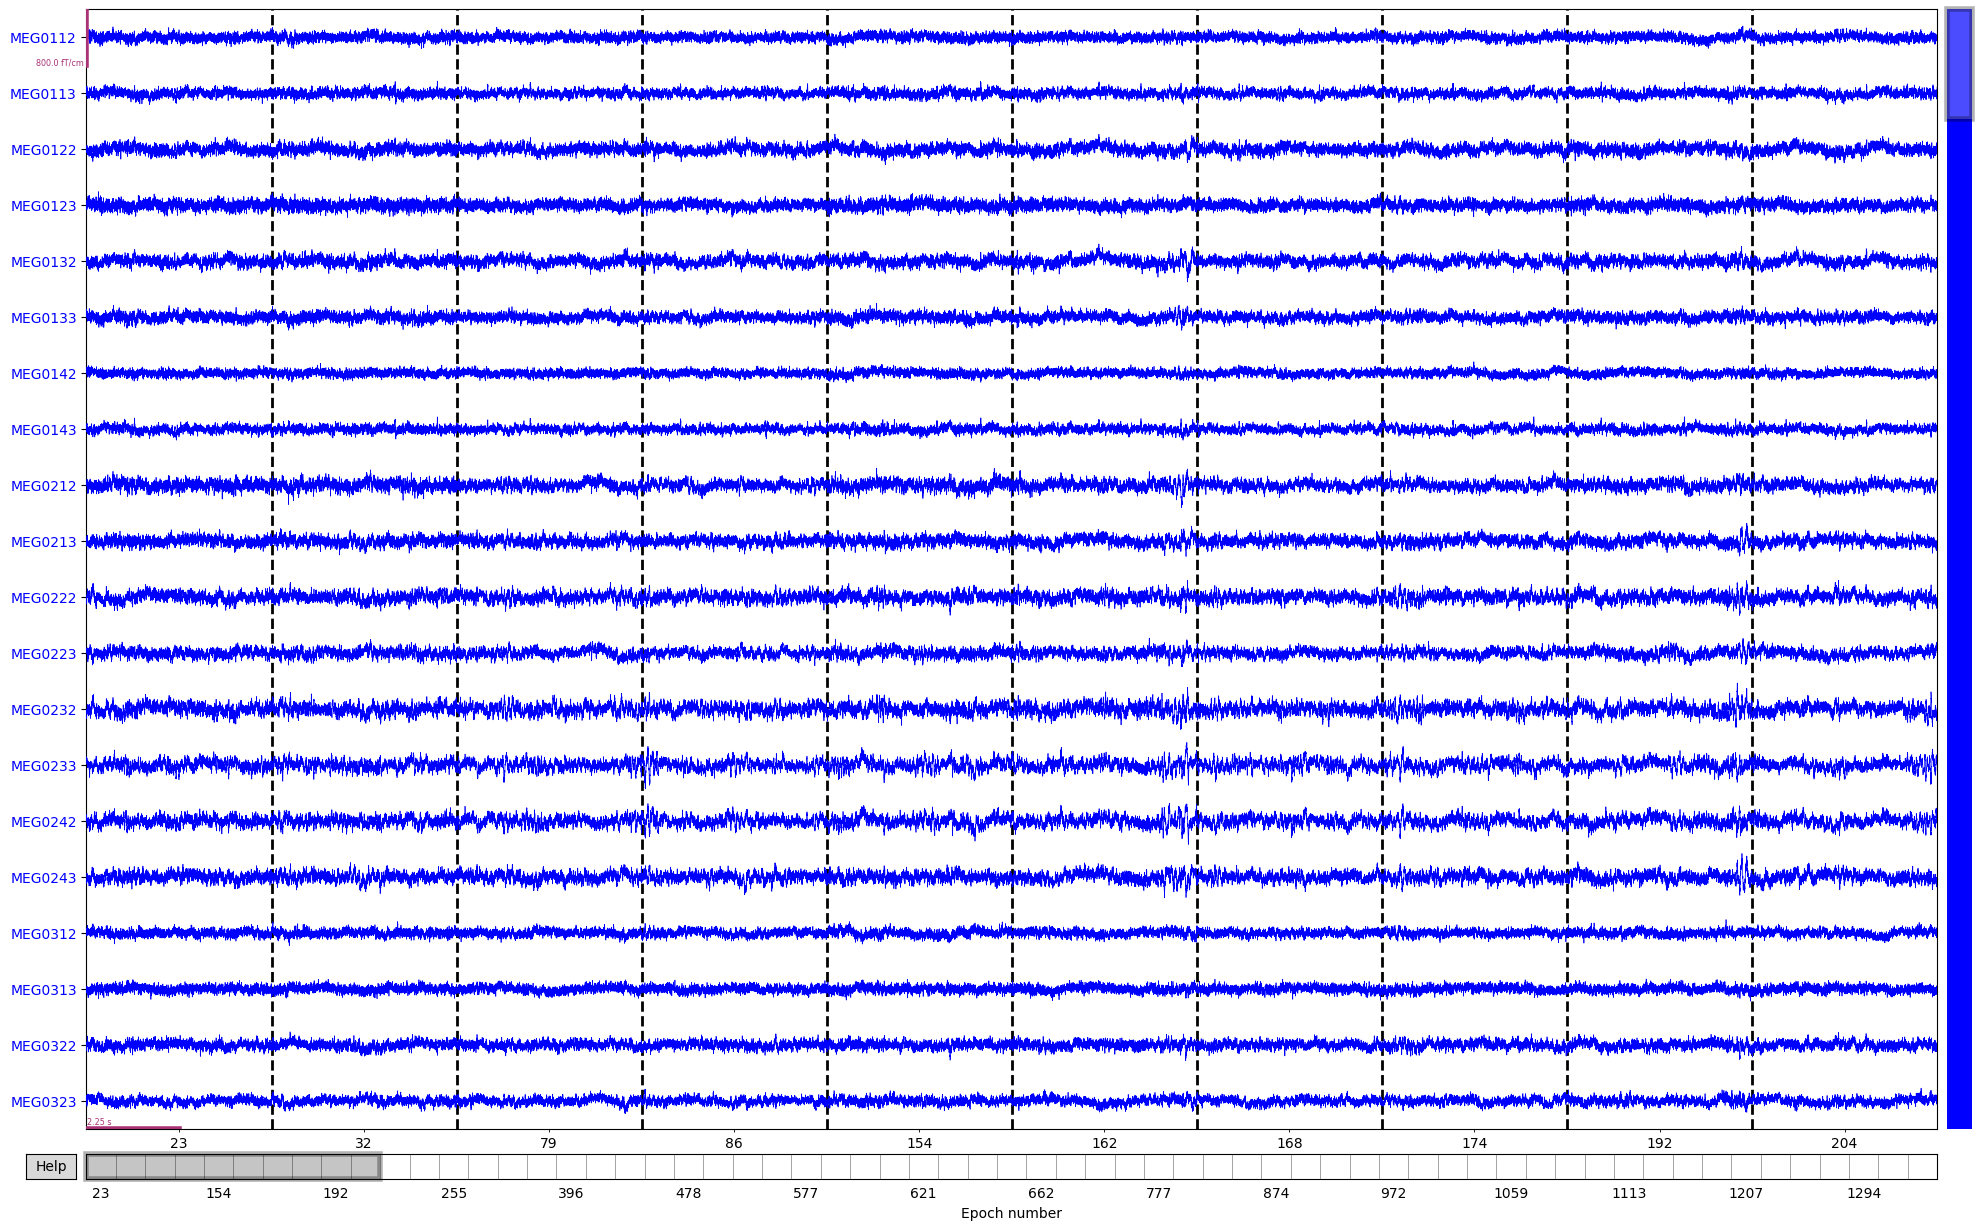

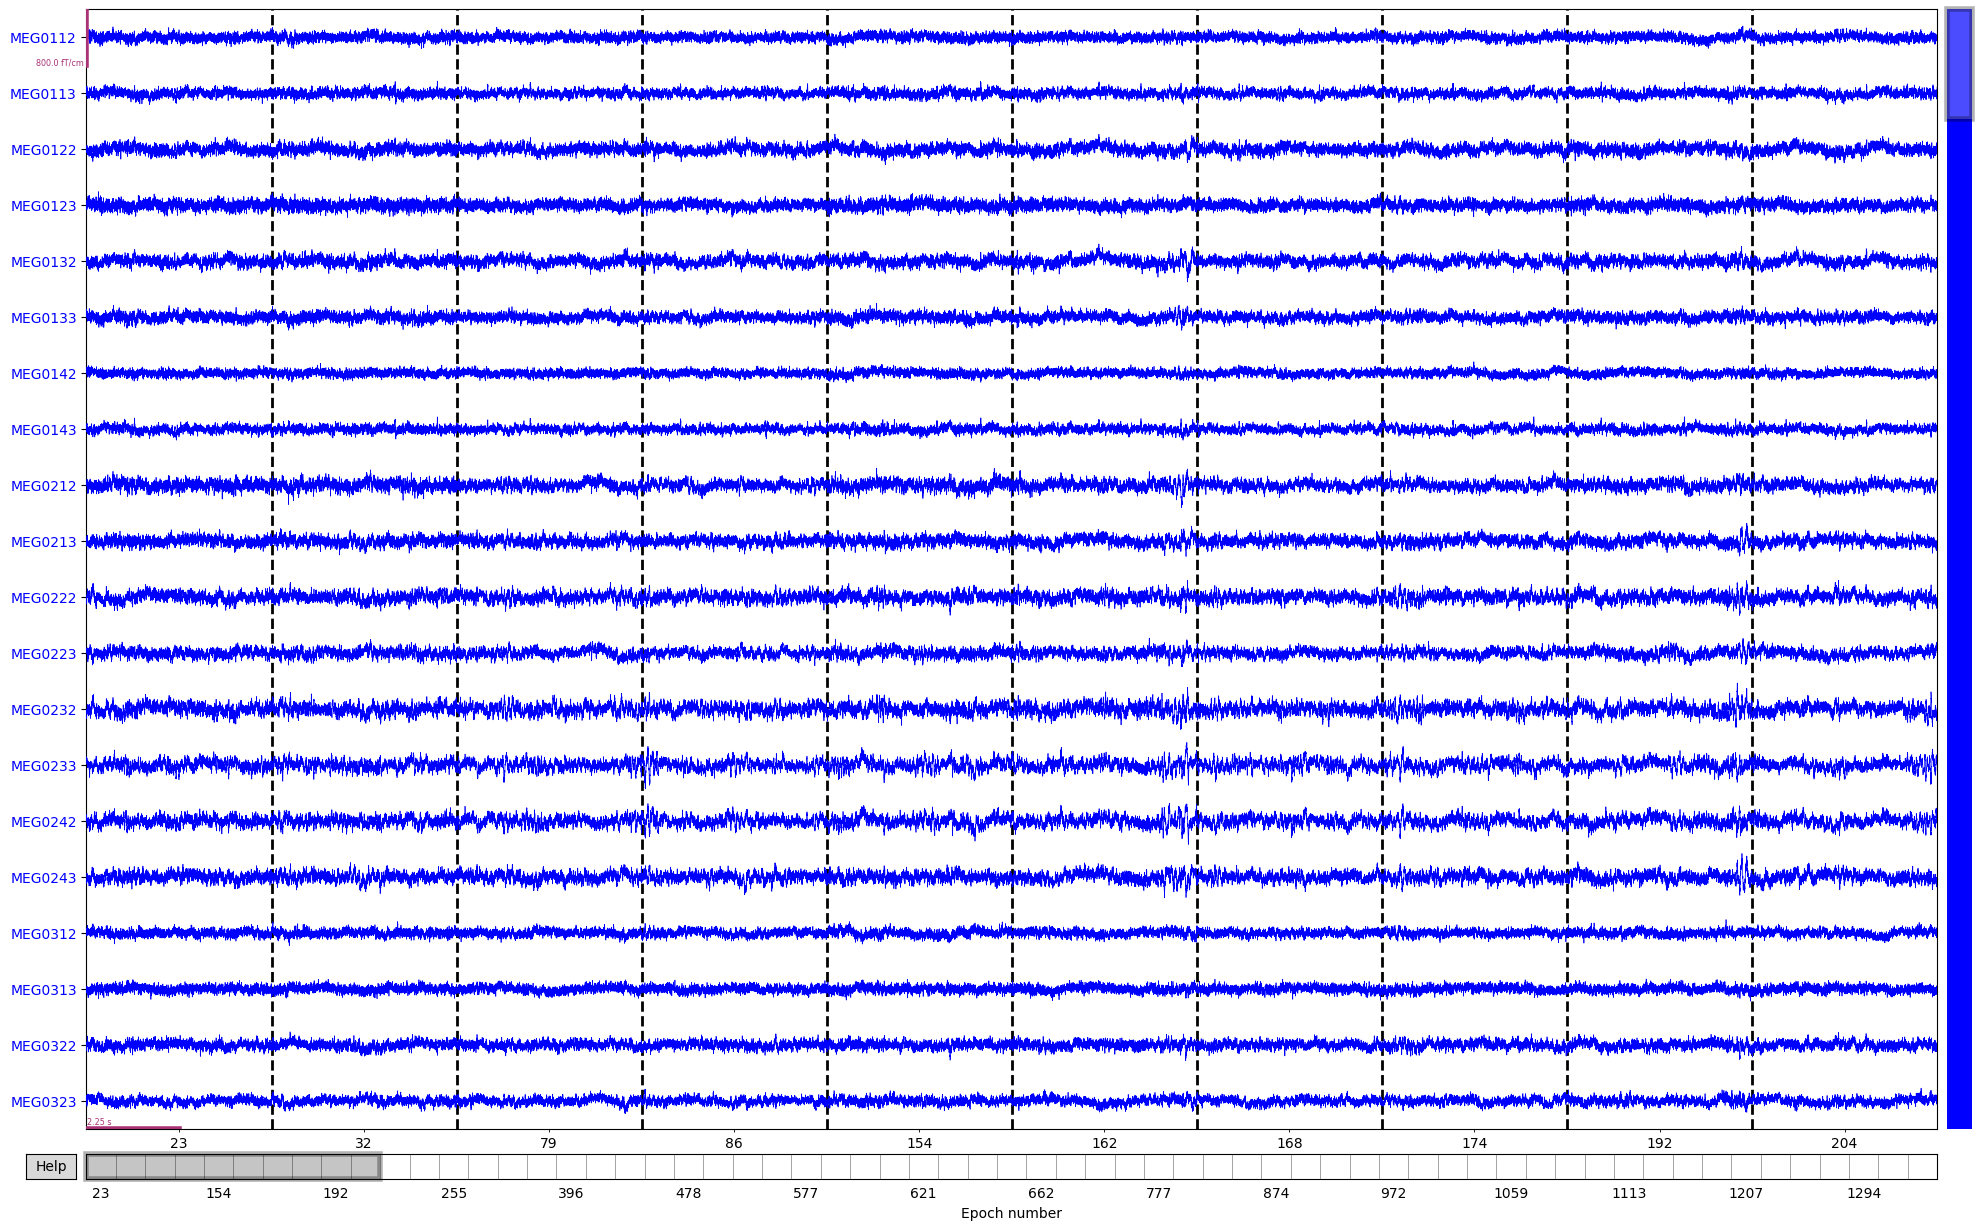

In [19]:
%matplotlib inline
epochs['cue_left'].plot(n_epochs=10, picks=['grad'])

上图显示了左注意力实验类型的10次试次；只显示了梯度仪。

要显示触发器（刺激通道），请写入：

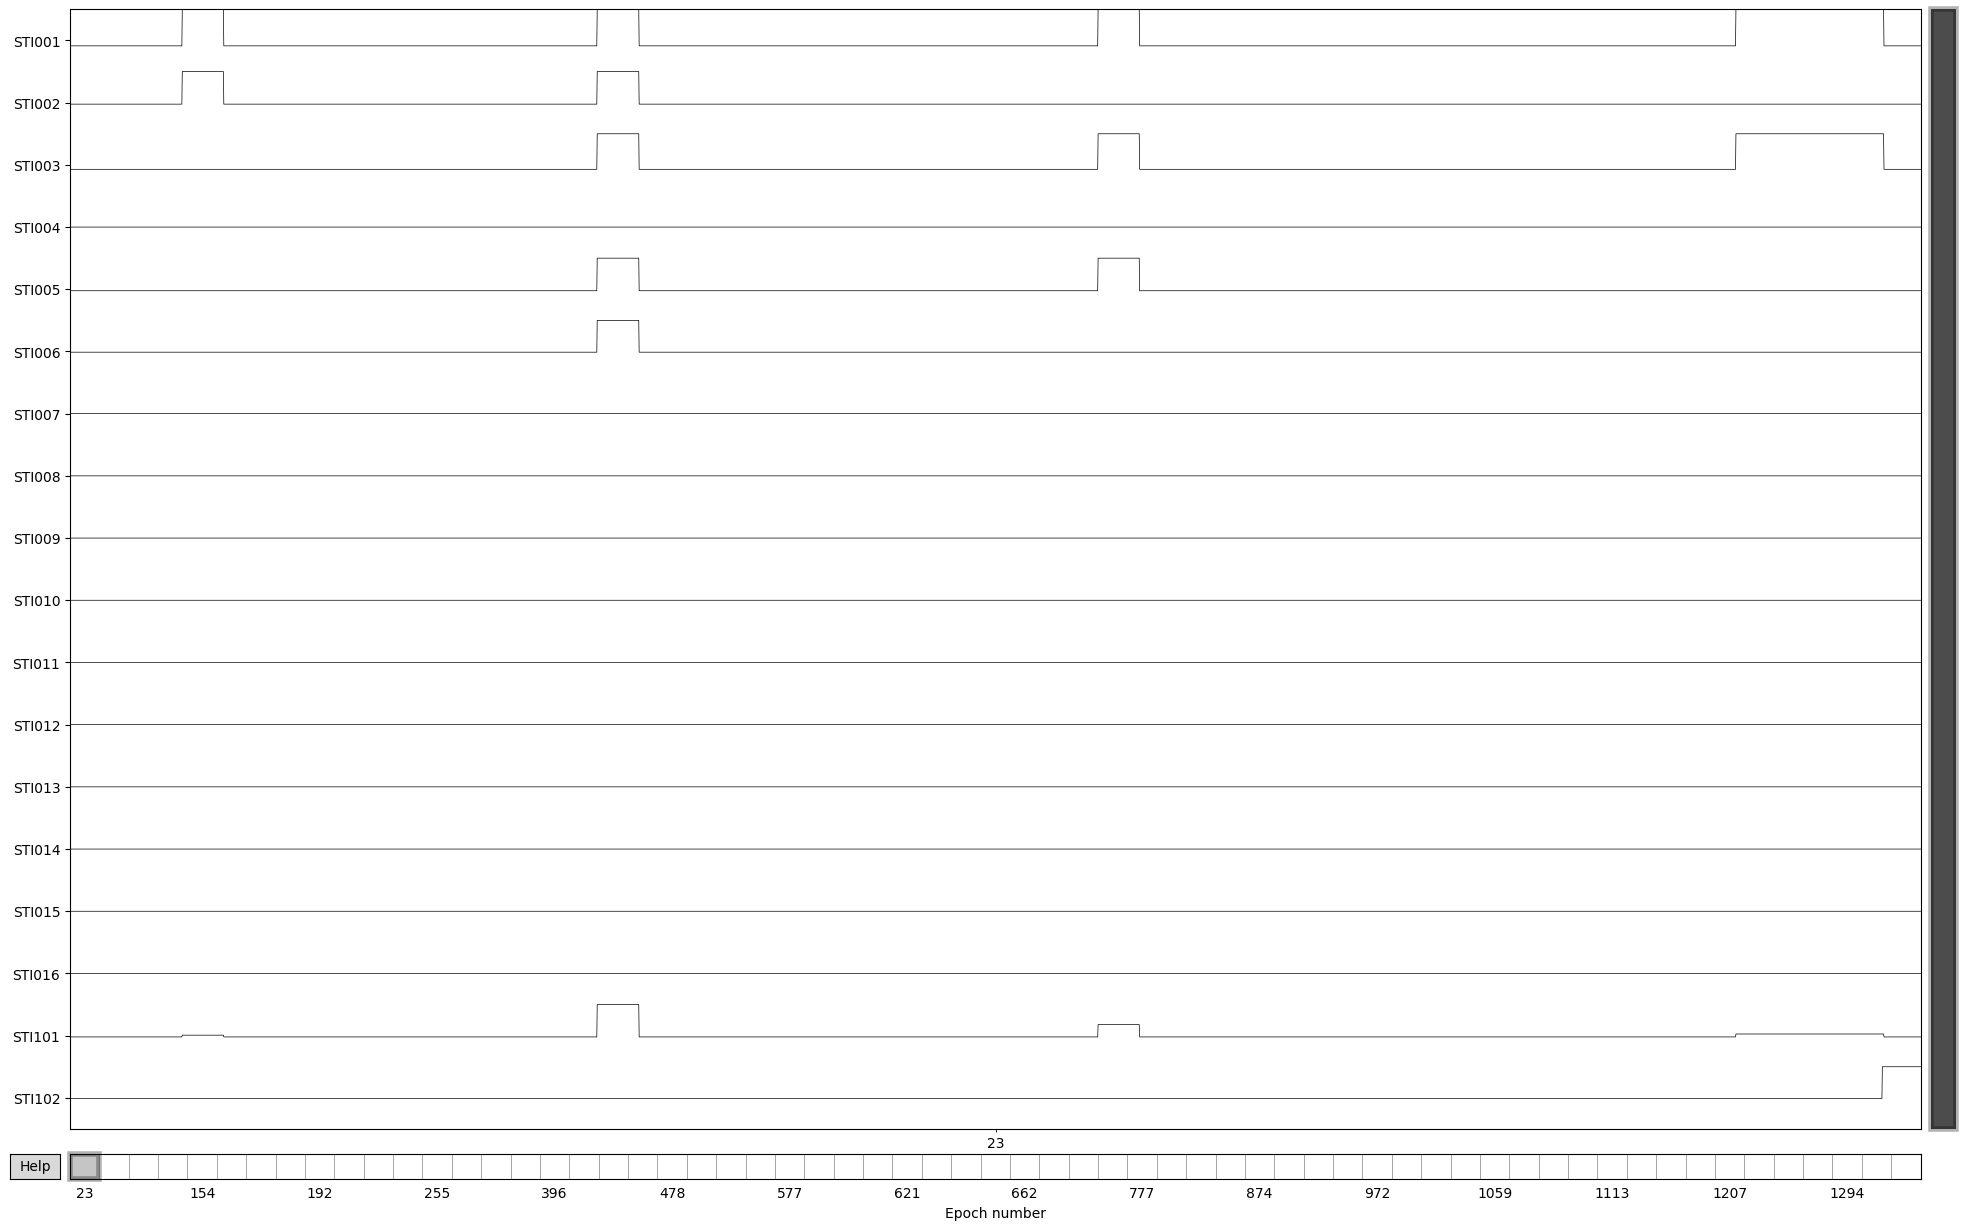

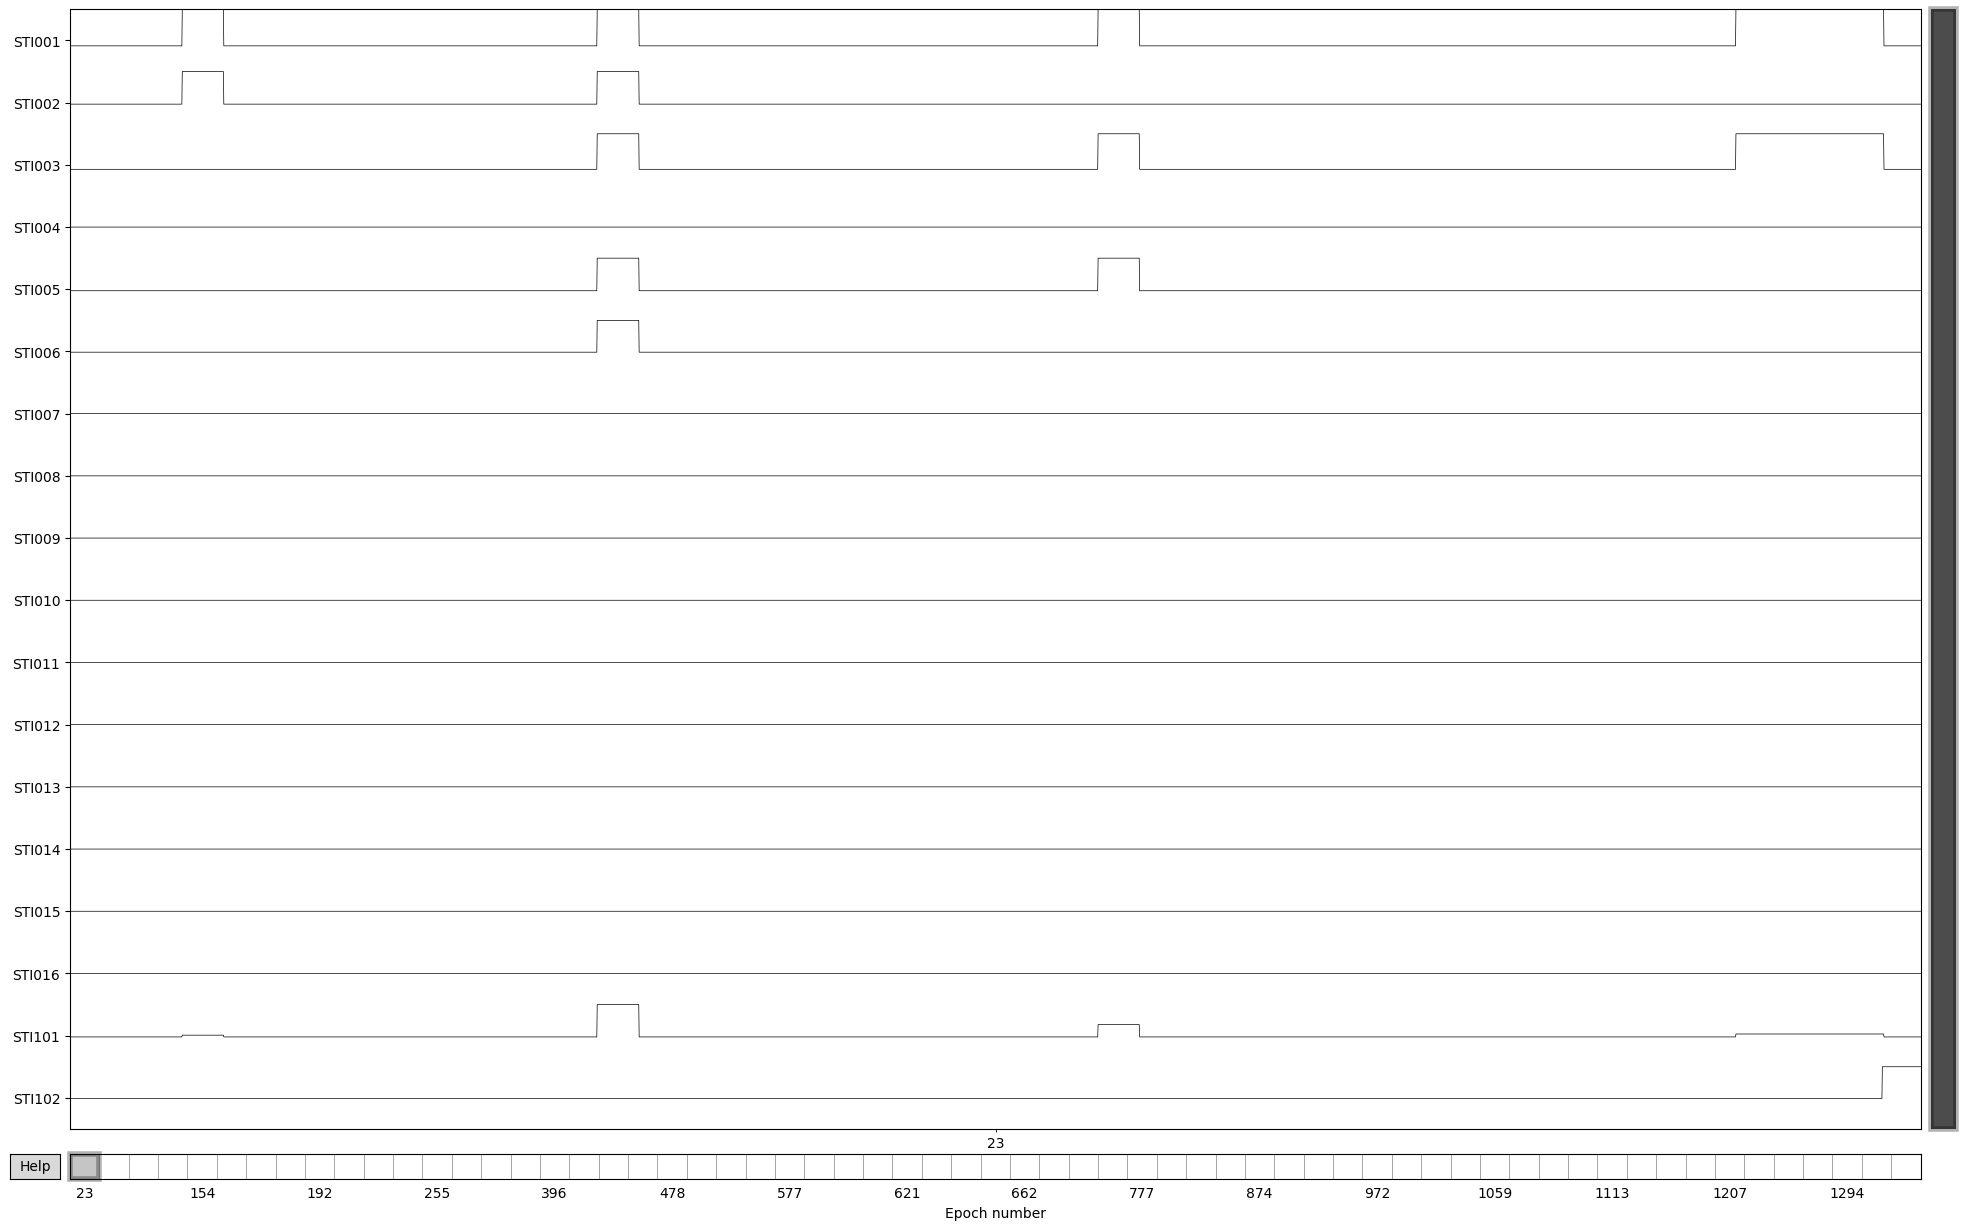

In [20]:
%matplotlib inline
epochs['cue_left'].plot(n_epochs=1, picks=['stim'])

一次试验的触发通道示例。

显示触发通道通常有助于验证是否选择了正确的试验。请注意，STI001到STI016表示“开”（1）或“关”（0）的单个触发线。通道STI101是触发线的组合（STI101=STI001+2* STI002+4* STI003+8* STI004+…）

要显示属于*左*的代表性梯度仪（MEG2343）的所有试次，请使用plot_image函数。在以下示例中，我们还使用30 Hz低通过滤每个单独的试次并将它们（裁剪）缩短到-100到400 ms间隔：

Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 441 samples (0.441 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    0.8s
[Parallel(n_job

Not setting metadata
63 matching events found
No baseline correction applied
0 projection items activated


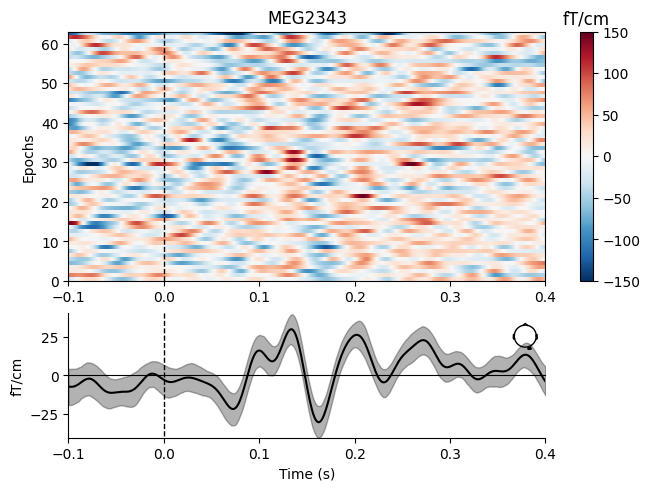

[<Figure size 640x480 with 4 Axes>]

In [21]:
%matplotlib inline
epochs['cue_left'].filter(0.0,30).crop(-0.1,0.4).plot_image(picks=['MEG2343'], vmin=-150, vmax=150)

## Preregistration and publications

Publication, example:

"The data were segmented into intervals of 4.5 s, ranging from 2.5 s prior to stimulus onset and 2 s after. To ensure that no artefacts were missed, trials in which the gradiometers values exceeded 5000 fT/cm or magnetometers exceeded 5000 fT were rejected as well as trials previously annotated with muscle artefacts."
